# Interpretable Machine Learning: PD2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from xgboost import XGBClassifier

Przekopiowałem kod do wczytywania i transformacji danych oraz trenowania modelu z PD1.

In [2]:
path = r'D:\Interpretable Machine Learning\PD1\HCMST 2017 fresh sample for public sharing draft v1.1.dta'
data = pd.read_stata(path)

In [3]:
variables = ['ppage', 'w6_q24_length', 'w6_sex_frequency', 'w6_q23', 'w6_q27']
# Selecting variables
X = data[variables]
# Filtering observations
logical_filter = (~data.w6_q23.isna()) & (data.w6_q23 != 'Refused') & (data.w6_q27 != 'Refused')
X = X[logical_filter]
# Casting types and imputation
X.ppage = X.ppage.astype(float)
X.w6_q24_length = X.w6_q24_length.astype(float)
X.w6_sex_frequency = X.w6_sex_frequency.cat.codes.replace({-1:5, 0:5})
X.w6_q23 = X.w6_q23.astype(str)
X.w6_q27 = X.w6_q27.astype(str)
# One Hot Encoding
X = pd.get_dummies(X)
X.columns = map(lambda x: x.replace('[Partner Name]', 'PARTNER'), X.columns)

y = 1 - data.S1.cat.codes
y = y[logical_filter]

In [4]:
xgb = XGBClassifier(seed=123)
xgb.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
       silent=True, subsample=1)

## Definicje funkcji rysujących wykresy

In [5]:
def cp_profile(model, obs, var, X, no_points, xmax=None, subplot=None):
    # Prepare dataframe for prediction
    obs = pd.DataFrame(obs).transpose()
    df = pd.concat([obs]*no_points)
    if xmax:
        df[var] = np.linspace(X[var].min(), xmax, no_points)
    else:
        df[var] = np.linspace(X[var].min(), X[var].max(), no_points)
    # Produce predictions
    preds = model.predict_proba(df)[:,1]
    # Create CP profile
    if subplot != None:
        plt.subplot(*subplot)
    plt.plot(df[var], preds, 'grey')
    plt.xlabel(var)
    plt.ylabel('Probability of being married')
    plt.title('Ceteris Paribus profile for variable ' + var)
    plt.scatter(obs[var], model.predict_proba(obs)[:,1], c=(0.8,0,0))
    if not subplot:
        plt.show()

In [6]:
def pdp(model, var, X, no_points, xmax=None, subplot=None):
    df = pd.concat([X] * no_points)
    if xmax:
        df[var] = np.repeat(np.linspace(X[var].min(), xmax, no_points), X.shape[0])
    else:
        df[var] = np.repeat(np.linspace(X[var].min(), X[var].max(), no_points), X.shape[0])
    df['preds'] = model.predict_proba(df)[:,1]
    df = df.groupby(var).agg({'preds':'mean'})
    # Plot PDP
    if subplot != None:
        plt.subplot(*subplot)
    plt.plot(df, 'grey')
    plt.xlabel(var)
    plt.ylabel('Probability of being married')
    plt.title('Partial Dependence Plot for variable ' + var)
    if not subplot:
        plt.show()

Moja implementacja ALE działa dla zmiennych ciągłych, przedziały są wyznaczane w oparciu o kwantyle wybranej zmiennej, tak jak jest to sugerowane w [oryginalnej pracy](https://arxiv.org/ftp/arxiv/papers/1612/1612.08468.pdf).

In [7]:
def ale(model, var, X, no_intervals, xlim=None, subplot=None):
    df = X.assign(q = pd.qcut(X[var], no_intervals, duplicates='drop'))
    # Creating dataframes with variable of interest as lower and upper bound of the corresponding bin
    X_lower = X.copy()
    X_lower[var] = df.q.apply(lambda x: x.left).astype(float)
    X_upper = X.copy()
    X_upper[var] = df.q.apply(lambda x: x.right).astype(float)
    # Predictions for both dataframes
    preds_lower = model.predict_proba(X_lower)[:,1]
    preds_upper = model.predict_proba(X_upper)[:,1]

    # Computing differences
    df = df.assign(diff = preds_upper - preds_lower)
    # Aggregating
    df = df.groupby('q').agg({'diff':'mean', 'q':'count'}).fillna(0)
    df = df.assign(x = df.index.to_series().apply(lambda x: x.right).astype(float),
                   diff_cum = df['diff'].cumsum())
    norm_const = df['diff_cum'].values.T @ df['q'] / X.shape[0]
    x = [float(df.index.to_series().iloc[0].left)] + df['x'].to_list()
    ale = [-norm_const] + (df['diff_cum'] - norm_const).to_list()
    
    # Plot ALE
    if subplot != None:
        plt.subplot(*subplot)
    plt.plot(x, ale, 'grey')
    if xlim:
        plt.xlim(xlim)
    plt.xlabel(var)
    plt.ylabel('Accumulated Local Effect')
    plt.title('Accumulated Local Effects Plot for variable ' + var)
    if not subplot:
        plt.show()

## Porównanie CP Profiles, PDP, ALE

Analogicznie do PD1, jako przykładową obserwację wybrano 32-letnią osobę, która o poznaniu swojego partnera napisała 348 znaków. Z partnerem uprawiała seks 3 do 6 razy w tygodniu; w 2016 roku zarobiła więcej niż partner oraz dorastała z partnerem w tej samej miejscowości. Osoba ta nie była w związku małżeńskim.

### Wiek

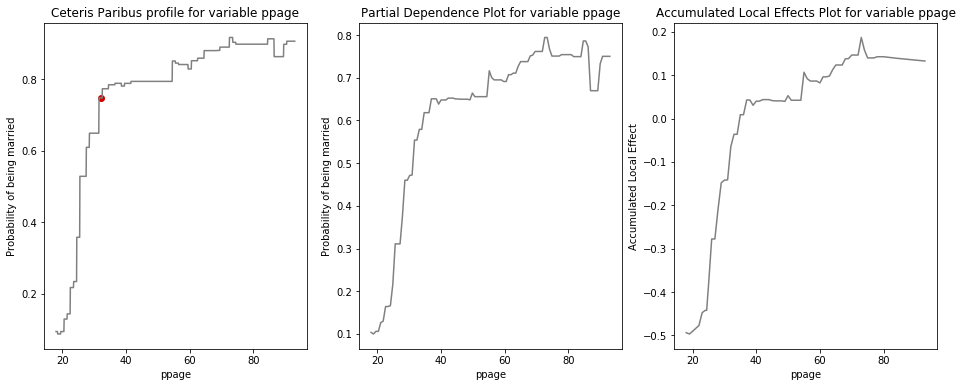

In [8]:
plt.figure(figsize=(16,6))
cp_profile(xgb, X.iloc[23, ], 'ppage', X, 1000, subplot=(1,3,1))
pdp(xgb, 'ppage', X, 100, subplot=(1,3,2))
ale(xgb, 'ppage', X, 100, subplot=(1,3,3))
plt.show(block=True)

Analogicznie do profilu CP, zgodnie z PDP i ALE prawdopodobieństwo pozostawania w związku małżeńskim wzrasta wraz z wiekiem. Wykres ALE jest najstabilniejszy i nie wydaje się, żeby pozostałe zmienne miały mieć duży wpływ na odpowiedź modelu w związku z korelacją.

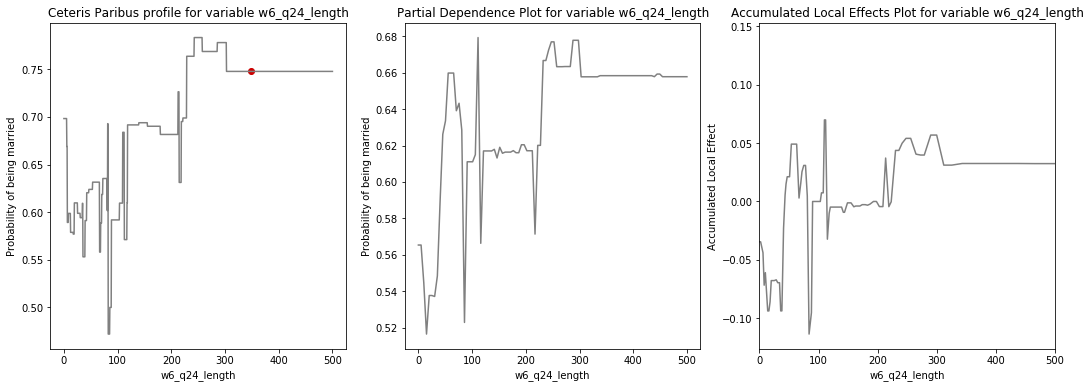

In [9]:
plt.figure(figsize=(18,6))
cp_profile(xgb, X.iloc[23, ], 'w6_q24_length', X, 1000, 500, subplot=(1,3,1))
pdp(xgb, 'w6_q24_length', X, 100,500, subplot=(1,3,2))
ale(xgb, 'w6_q24_length', X, 100, (0,500), subplot=(1,3,3))
plt.show(block=True)

Analogicznie do PD1 zmniejszyłem zakres, żeby uwidocznić wahanie wykresów dla mniejszych wartości (`w6_q24_length` ma mocno skośny rozkład). Tutaj widać mocno nieliniową zalezność. Piki w okolicy 100 i 200 występują na PDP i ALE, przez co można sądzić, że pisanie odpowiedzi na pytanie 24 o takiej długości dostarcza dużo informacji o byciu lub nie w związku małżeńskim. Z drugiej strony, skala wykresu jest niewielka w porównaniu do wykresów dla wieku, więc wahania można uznać za nieduże.